In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

# Extended vs. binned likelihood
- generate data as a sum of gaussian signal $\sim \mathcal N (\mu_s, \sigma_s)$ and flat background $\sim U(E_{n}^{min}, E_n^{max})$
	- $\mu_s = 2039~\mathrm{KeV}$
	- $\sigma_s = 15~\mathrm{KeV}$
	- $E_n^{min} = 2000~\mathrm{KeV}$
	- $E_n^{min} = 2080~\mathrm{KeV}$
- consider all combinations of numbers of signal and background events $s = \{ 5, 20, 50, 100 \}$ and $b = \{ 10, 30, 100, 200 \}$
- for each combination generate $10^4$ Toy MC data sets
- fit each Toy MC set with
	- extended likelihood method
	- binned likelihood with $1~\mathrm{KeV}$ binning
- benchmark both methods in terms of CPU time
- for each $s$ + $b$ + fit type combination plot $t_{extended} / t_{binned}$ vs $N_{events} / N_{bins}$

In [20]:
from dataclasses import dataclass
import time


E_MIN = 2000
E_MAX = 2080
E_PEAK = 2039
E_PEAK_SIGMA = 10


@dataclass
class FitResult:
    s_est: float
    b_est: float
    time: float


@dataclass
class FitResultsComparison:
    extended: FitResult
    extended_full: FitResult | None
    binned: FitResult


def compare_likelihood_methods(
    s_true: int,
    b_true: int,
    ax: plt.Axes | None,
    with_full_fit: bool = True,
    optimized: bool = True,
) -> FitResultsComparison:
    signal_rv = scipy.stats.norm(loc=E_PEAK, scale=E_PEAK_SIGMA)
    background_rv = scipy.stats.uniform(loc=E_MIN, scale=E_MAX - E_MIN)

    signal_sample = signal_rv.rvs(size=s_true)
    background_sample = background_rv.rvs(size=b_true)

    sample = np.concatenate([signal_sample, background_sample], axis=0)
    np.random.shuffle(sample)
    s_b_bounds = scipy.optimize.Bounds([0, 0], [np.inf, np.inf])

    ########################################################
    # extended likelihood fit w/ known signal shape
    start = time.time()
    background_pdf_eval = background_rv.pdf(sample)
    signal_pdf_eval = signal_rv.pdf(sample)

    def negloglike_extended(theta: np.ndarray) -> float:
        s, b = theta
        return (
            s
            + b
            - np.sum(
                np.log(
                    s * (signal_pdf_eval if optimized else signal_rv.pdf(sample))
                    + b
                    * (background_pdf_eval if optimized else background_rv.pdf(sample))
                )
            )
        )

    res = scipy.optimize.minimize(
        negloglike_extended,
        np.array([len(sample) / 2, len(sample) / 2]),
        bounds=s_b_bounds,
    )
    extended_fr = FitResult(s_est=res.x[0], b_est=res.x[1], time=time.time() - start)

    ########################################################
    # extended likelihood fit w/ signal shape fit
    extended_full_fr: FitResult | None = None
    if with_full_fit:
        start = time.time()
        background_pdf_eval = background_rv.pdf(sample)

        def negloglike_extended_full(theta: np.ndarray) -> float:
            s, b, mu, sigma = theta
            return (
                s
                + b
                - np.sum(
                    np.log(
                        s * scipy.stats.norm.pdf(sample, loc=mu, scale=sigma)
                        + b * background_pdf_eval
                    )
                )
            )

        res = scipy.optimize.minimize(
            negloglike_extended_full,
            np.array([len(sample) / 2, len(sample) / 2, sample.mean(), sample.std()]),
            bounds=scipy.optimize.Bounds(
                [0, 0, E_MIN, 0], [np.inf, np.inf, E_MAX, np.inf]
            ),
        )
        extended_full_fr = FitResult(
            s_est=res.x[0], b_est=res.x[1], time=time.time() - start
        )
        extended_full_mu_est = res.x[2]
        extended_full_sigma_est = res.x[3]

    ########################################################
    # binned likelihood fit
    start = time.time()
    binning_step = 1  # KeV
    bin_edges = np.linspace(E_MIN, E_MAX, num=1 + (E_MAX - E_MIN) // binning_step)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    signal_pdf_eval_bc = signal_rv.pdf(bin_centers)
    background_pdf_eval_bc = background_rv.pdf(bin_centers)
    binned_sample, _ = np.histogram(
        sample,
        bins=bin_edges,
    )

    def negloglike_binned(theta: np.ndarray) -> float:
        s, b = theta
        return -np.sum(
            binned_sample
            * np.log(
                (
                    s
                    * (signal_pdf_eval_bc if optimized else signal_rv.pdf(bin_centers))
                    + b
                    * (
                        background_pdf_eval_bc
                        if optimized
                        else background_rv.pdf(bin_centers)
                    )
                )
                / (s + b)
            )
        )

    res = scipy.optimize.minimize(
        negloglike_binned,
        np.array([len(sample) / 2, len(sample) / 2]),
        bounds=s_b_bounds,
    )
    binned_fr = FitResult(s_est=res.x[0], b_est=res.x[1], time=time.time() - start)

    ########################################################
    # plotting
    if ax is not None:
        E_range = np.linspace(E_MIN, E_MAX, num=500)
        E_bins = np.linspace(E_MIN, E_MAX, num=min(50, (s_true + b_true) // 3))
        ax.hist(
            [
                background_sample,
                signal_sample,
            ],
            bins=E_bins,
            stacked=True,
            density=True,
            # label=["Background", "Signal"],
        )

        def plot_mixture_pdf(
            s: float,
            b: float,
            color: str,
            label: str,
            signal_rv_override: scipy.stats.rv_continuous | None = None,
            is_dashed: bool = False,
        ):
            ax.plot(
                E_range,
                (
                    b * background_rv.pdf(E_range)
                    + s * (signal_rv_override or signal_rv).pdf(E_range)
                )
                / (s + b),
                color=color,
                label=label,
                linestyle="--" if is_dashed else None,
            )

        plot_mixture_pdf(s_true, b_true, "k", "True PDF")
        plot_mixture_pdf(
            extended_fr.s_est,
            extended_fr.b_est,
            "r",
            "Extended $ \\mathcal{L} $",
            # is_dashed=True,
        )
        if with_full_fit:
            plot_mixture_pdf(
                extended_full_fr.s_est,
                extended_full_fr.b_est,
                "b",
                "Extended $ \\mathcal{L} $ w/ pulse",
                signal_rv_override=scipy.stats.norm(
                    loc=extended_full_mu_est,
                    scale=extended_full_sigma_est,
                ),
            )
        plot_mixture_pdf(
            binned_fr.s_est,
            binned_fr.b_est,
            "g",
            "Binned $ \\mathcal{L} $",
            # is_dashed=True,
        )

        ax.set_yticks([])
        ax.set_xlim(E_MIN, E_MAX)
        ax.legend()

    return FitResultsComparison(
        extended=extended_fr,
        extended_full=extended_full_fr,
        binned=binned_fr,
    )

/Users/njvh/Documents/Science/GSSI/STAT/venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


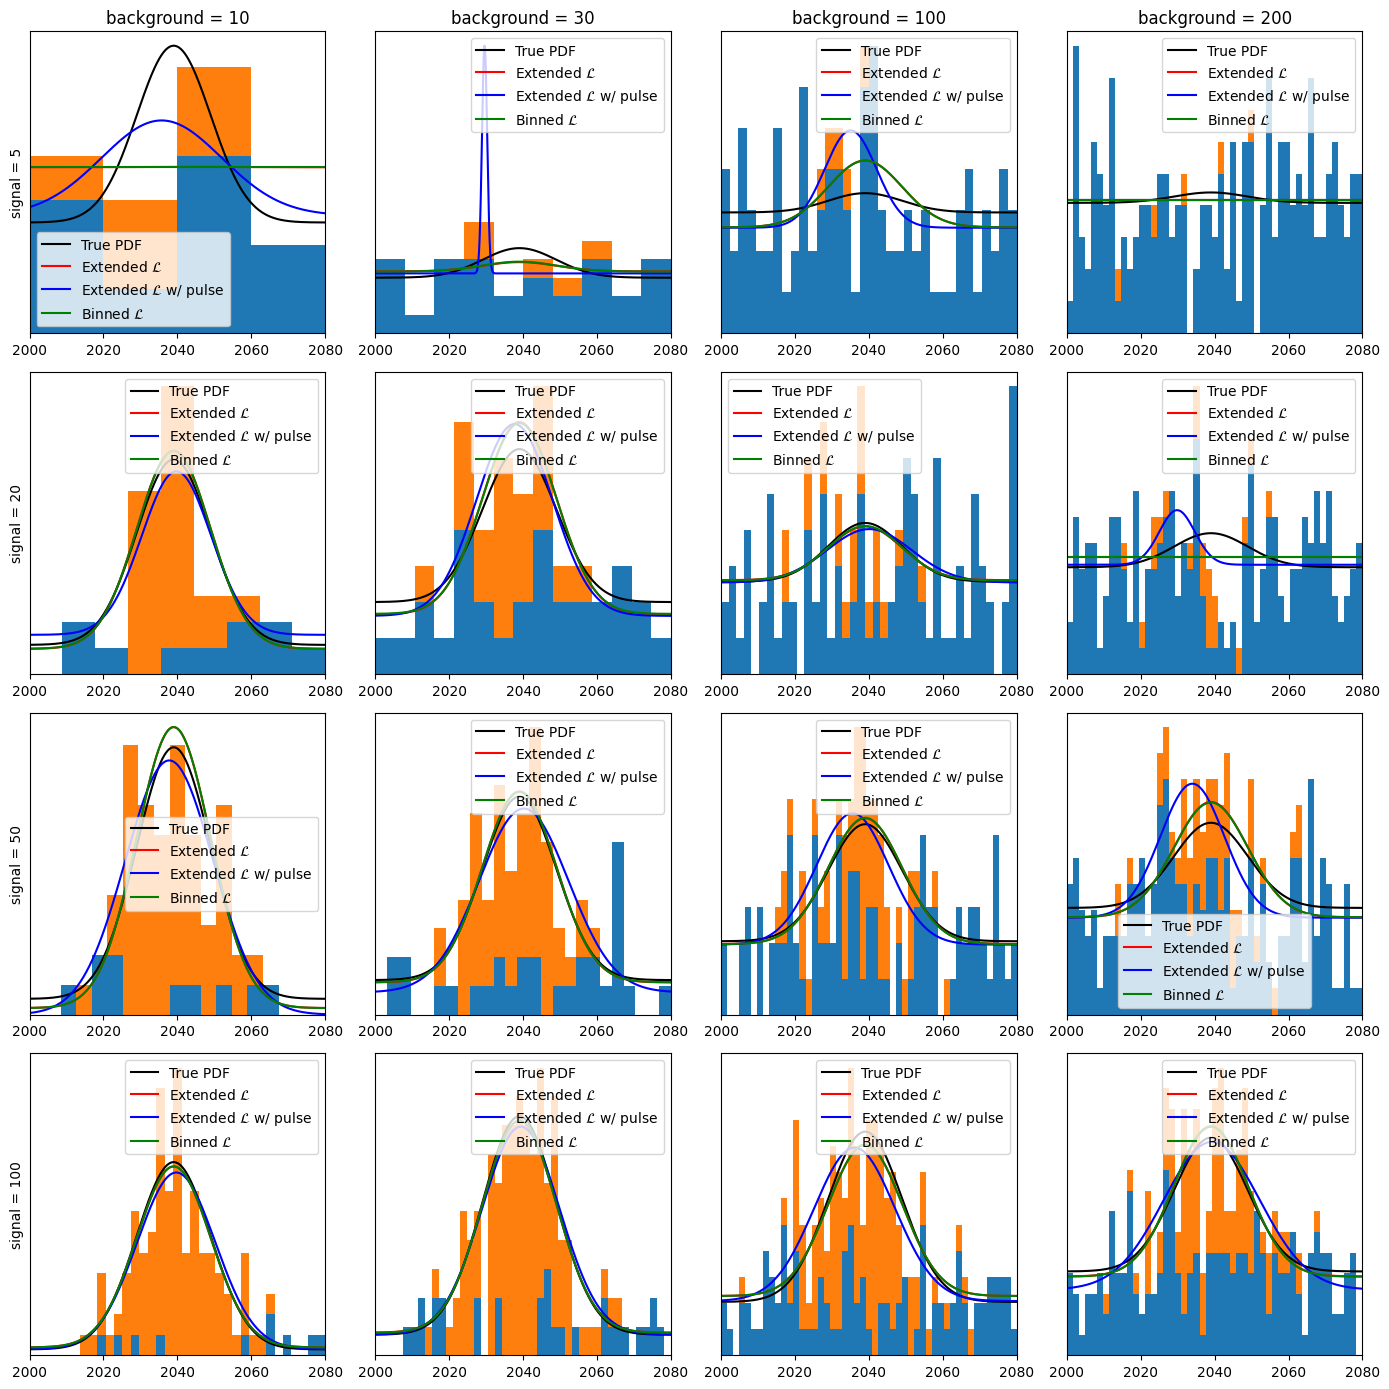

In [21]:
s_options = [5, 20, 50, 100]
b_options = [10, 30, 100, 200]
fig, axes = plt.subplots(
    nrows=len(s_options),
    ncols=len(b_options),
    figsize=(3.5 * len(b_options), 3.5 * len(s_options)),
)

for s, ax_row in zip(s_options, axes):
    ax_row[0].set_ylabel(f"signal = {s}")
    for b, ax in zip(b_options, ax_row):
        compare_likelihood_methods(s, b, ax)
        if s == s_options[0]:
            ax.set_title(f"background = {b}")

plt.tight_layout()
plt.show()

100%|██████████| 640/640 [03:17<00:00,  3.24it/s]


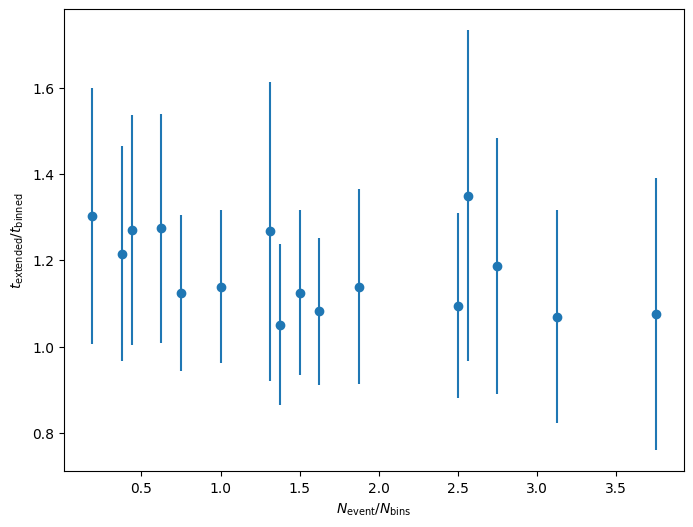

In [22]:
from tqdm import tqdm
s_options = [5, 20, 50, 100]
b_options = [10, 30, 100, 200]
comparisons_count = 40

t_fraction_mean = []
t_fraction_std = []
n_fraction = []
with tqdm(total=len(s_options) * len(b_options) * comparisons_count) as progress_bar:
    for s in s_options:
        for b in b_options:
            n_fraction.append((s + b) / 80)
            t_frac_sample = []
            for _ in range(comparisons_count):
                res = compare_likelihood_methods(s, b, ax, with_full_fit=False)
                progress_bar.update()
                t_frac_sample.append(res.extended.time / res.binned.time)
            t_fraction_mean.append(np.mean(t_frac_sample))
            t_fraction_std.append(np.std(t_frac_sample))

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(n_fraction, t_fraction_mean, t_fraction_std, linestyle="", marker="o")
ax.set_xlabel("$ N_{\mathrm{event}} / N_{\mathrm{bins}} $")
ax.set_ylabel("$ t_{\mathrm{extended}} / t_{\mathrm{binned}} $")
plt.show()